In [54]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        
        
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns



# Texas Wind Turbine Dataset (simulated)

## Investigation into forecasting the next 24 hours power output based on the provided dataset. 

## Dataset has perfect data completion so no need to drop any null values or impute missing values

In [185]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import pandas_profiling
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #MinMaxScaler #

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor



In [56]:
# to get the plots to show in the same size
%matplotlib inline
plt.rcParams['figure.figsize'] = (25, 10)

In [57]:

# import the data and set the time column as the index

df = pd.read_csv('/home/chris/kaggle/texas_wind_turbine/TexasTurbine.csv',parse_dates=['Time stamp'])
#df = pd.read_csv('/kaggle/input/input/texas-wind-turbine-dataset-simulated/TexasTurbine.csv',parse_dates=['Time stamp']) #,index_col=['Time stamp'])

## Since time is in the 12 hour am/pm format it needs to be converted to 24 time. Then it can be set as the index. Also the year is not explicitly given and it doesn't matter as there is only 1 year of data. Python nominally sets the year to 1900 - but it can be ignored.

In [58]:
# get it in the correct format - by adding minutes and nanosecond
df['Time stamp'] = pd.to_datetime(df['Time stamp'], format='%b %d, %I:%M %p').dt.strftime('%b %d %H:%M:%S.%f')

In [59]:
# then use a lambda function to convert to datetime if it is a string else make is Not a Time
df['Time stamp'] = df['Time stamp'].apply(lambda x: dt.datetime.strptime(x,'%b %d %H:%M:%S.%f') if type(x)==str else pd.NaT)
df['Time stamp'].dtype

dtype('<M8[ns]')

In [60]:
# set the index
df = df.set_index(df['Time stamp']) 
# and drop the timestamp column
df.drop(columns = 'Time stamp',inplace=True)

In [61]:
#df.set_index('Time stamp')
#df.index = pd.to_datetime(df.index)
df

System power generated | (kW)  Wind speed | (m/s)  \
Time stamp                                                               
1900-01-01 00:00:00                        1766.64               9.926   
1900-01-01 01:00:00                        1433.83               9.273   
1900-01-01 02:00:00                        1167.23               8.660   
1900-01-01 03:00:00                        1524.59               9.461   
1900-01-01 04:00:00                        1384.28               9.184   
...                                            ...                 ...   
1900-12-31 19:00:00                        1234.70               8.848   
1900-12-31 20:00:00                        1105.37               8.502   
1900-12-31 21:00:00                        1405.71               9.224   
1900-12-31 22:00:00                        1221.36               8.799   
1900-12-31 23:00:00                        1676.77               9.748   

                     Wind direction | (deg)  Pressure | (atm)  \
Time stamp                                                      
1900-01-01 00:00:00                     128          1.000480   
1900-01-01 01:00:00                     135          0.999790   
1900-01-01 02:00:00                     142          0.999592   
1900-01-01 03:00:00                     148          0.998309   
1900-01-01 04:00:00                     150          0.998507   
...                                     ...               ...   
1900-12-31 19:00:00                     129          0.998604   
1900-12-31 20:00:00                     118          1.000090   
1900-12-31 21:00:00                     117          0.998408   
1900-12-31 22:00:00                     116          0.998013   
1900-12-31 23:00:00                     121          1.000380   

                     Air temperature | ('C)  
Time stamp                                   
1900-01-01 00:00:00                  18.263  
1900-01-01 01:00:00                  18.363  
1900-01-01 02:00:00                  18.663  
1900-01-01 03:00:00                  18.763  
1900-01-01 04:00:00                  18.963  
...                                     ...  
1900-12-31 19:00:00                  19.663  
1900-12-31 20:00:00                  19.063  
1900-12-31 21:00:00                  18.463  
1900-12-31 22:00:00                  18.063  
1900-12-31 23:00:00                  18.163  

[8760 rows x 5 columns]

In [62]:
#  look  at the data 
df.head(24)

System power generated | (kW)  Wind speed | (m/s)  \
Time stamp                                                               
1900-01-01 00:00:00                       1766.640               9.926   
1900-01-01 01:00:00                       1433.830               9.273   
1900-01-01 02:00:00                       1167.230               8.660   
1900-01-01 03:00:00                       1524.590               9.461   
1900-01-01 04:00:00                       1384.280               9.184   
1900-01-01 05:00:00                       1293.930               8.996   
1900-01-01 06:00:00                       1301.630               9.016   
1900-01-01 07:00:00                       1308.130               9.036   
1900-01-01 08:00:00                        792.081               7.612   
1900-01-01 09:00:00                        399.537               6.129   
1900-01-01 10:00:00                        362.988               5.961   
1900-01-01 11:00:00                        951.359               8.117   
1900-01-01 12:00:00                       1549.750               9.540   
1900-01-01 13:00:00                       1835.220              10.094   
1900-01-01 14:00:00                       1208.370               8.789   
1900-01-01 15:00:00                        686.154               7.286   
1900-01-01 16:00:00                        624.105               7.088   
1900-01-01 17:00:00                        678.936               7.266   
1900-01-01 18:00:00                       1187.510               8.739   
1900-01-01 19:00:00                       1881.720              10.212   
1900-01-01 20:00:00                       1685.910               9.797   
1900-01-01 21:00:00                       1188.700               8.729   
1900-01-01 22:00:00                        939.228               8.087   
1900-01-01 23:00:00                        772.632               7.563   

                     Wind direction | (deg)  Pressure | (atm)  \
Time stamp                                                      
1900-01-01 00:00:00                     128          1.000480   
1900-01-01 01:00:00                     135          0.999790   
1900-01-01 02:00:00                     142          0.999592   
1900-01-01 03:00:00                     148          0.998309   
1900-01-01 04:00:00                     150          0.998507   
1900-01-01 05:00:00                     149          0.998507   
1900-01-01 06:00:00                     151          0.998211   
1900-01-01 07:00:00                     154          0.997815   
1900-01-01 08:00:00                     154          1.000280   
1900-01-01 09:00:00                     162          1.002950   
1900-01-01 10:00:00                     152          1.000480   
1900-01-01 11:00:00                     141          1.000680   
1900-01-01 12:00:00                     141          0.996926   
1900-01-01 13:00:00                     136          1.000280   
1900-01-01 14:00:00                     137          0.998801   
1900-01-01 15:00:00                     126          0.999986   
1900-01-01 16:00:00                     122          0.999591   
1900-01-01 17:00:00                     121          0.997715   
1900-01-01 18:00:00                     116          0.996334   
1900-01-01 19:00:00                     126          0.994952   
1900-01-01 20:00:00                     132          0.998406   
1900-01-01 21:00:00                     149          1.000480   
1900-01-01 22:00:00                     155          0.998210   
1900-01-01 23:00:00                     160          0.998703   

                     Air temperature | ('C)  
Time stamp                                   
1900-01-01 00:00:00                  18.263  
1900-01-01 01:00:00                  18.363  
1900-01-01 02:00:00                  18.663  
1900-01-01 03:00:00                  18.763  
1900-01-01 04:00:00                  18.963  
1900-01-01 05:00:00                  19.063  
1900-01-01 06:00:00                  

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 1900-01-01 00:00:00 to 1900-12-31 23:00:00
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   System power generated | (kW)  8760 non-null   float64
 1   Wind speed | (m/s)             8760 non-null   float64
 2   Wind direction | (deg)         8760 non-null   int64  
 3   Pressure | (atm)               8760 non-null   float64
 4   Air temperature | ('C)         8760 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 410.6 KB


In [64]:
df.describe()

System power generated | (kW)  Wind speed | (m/s)  \
count                    8760.000000         8760.000000   
mean                      964.467934            7.376120   
std                       878.558112            3.138291   
min                         0.000000            0.119000   
25%                       215.951500            5.121000   
50%                       693.968500            7.340500   
75%                      1562.287500            9.599000   
max                      3004.010000           19.743000   

       Wind direction | (deg)  Pressure | (atm)  Air temperature | ('C)  
count             8760.000000       8760.000000             8760.000000  
mean               146.616210          0.992368               22.147298  
std                 84.678754          0.005332                4.855232  
min                  0.000000          0.974514                3.263000  
25%                 99.000000          0.988925               19.463000  
50%                135.000000          0.991495               22.763000  
75%                169.000000          0.995045               26.063000  
max                360.000000          1.014510               32.963000

# Data exploration

## Let pandas do the preliminary exploratory data analysis. 

In [65]:
# Use panda_profiling library to investigate the data
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Visualising 

## A plot of power generation against wind speed.

## Investigating when the system power generated is zero - on 822 occasions out of 8761 - so roughly 10% of the time - Why ??

In [66]:
# how many values equal 0
(df[['System power generated | (kW)']]==0).sum()

System power generated | (kW)    822
dtype: int64

## Let's look at the wind speed when there is no power generated - all wind speeds are below 3m/s - so obviously the wind speed needs to be greater than about 3m/s  to turn the turbine and generate power - visualising this shows this fact - and that the graph is not linear.

Text(0.5, 1.0, 'Power output versus wind speed')

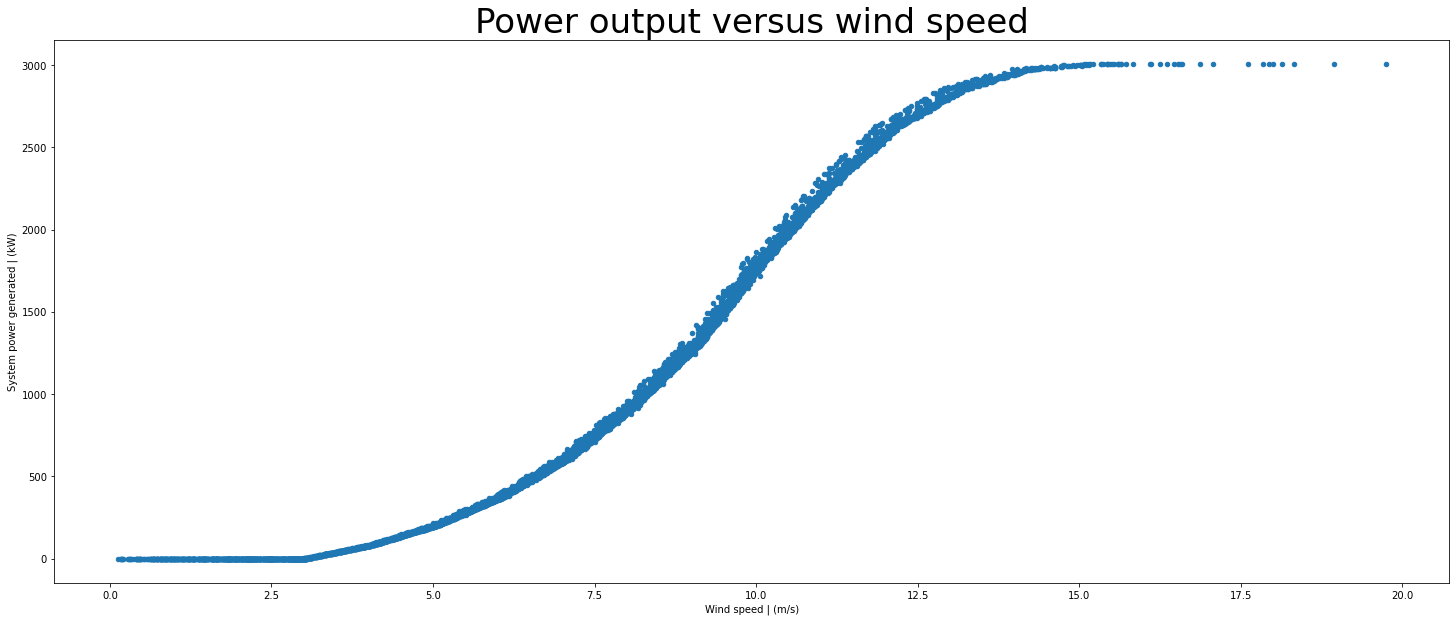

In [67]:
df.plot.scatter(y='System power generated | (kW)', x='Wind speed | (m/s)')
plt.title('Power output versus wind speed', fontsize=34 )

## In fact is looks like a logistic function - 
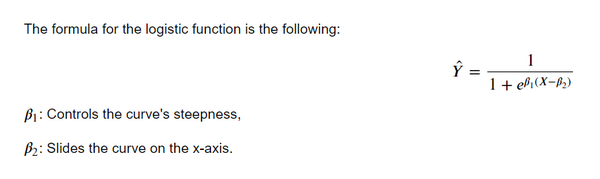

## A sample plot with some estimates for the parameters is shown below - (by altering these parameters the exact equation of the line could be worked out but that is not the task here)

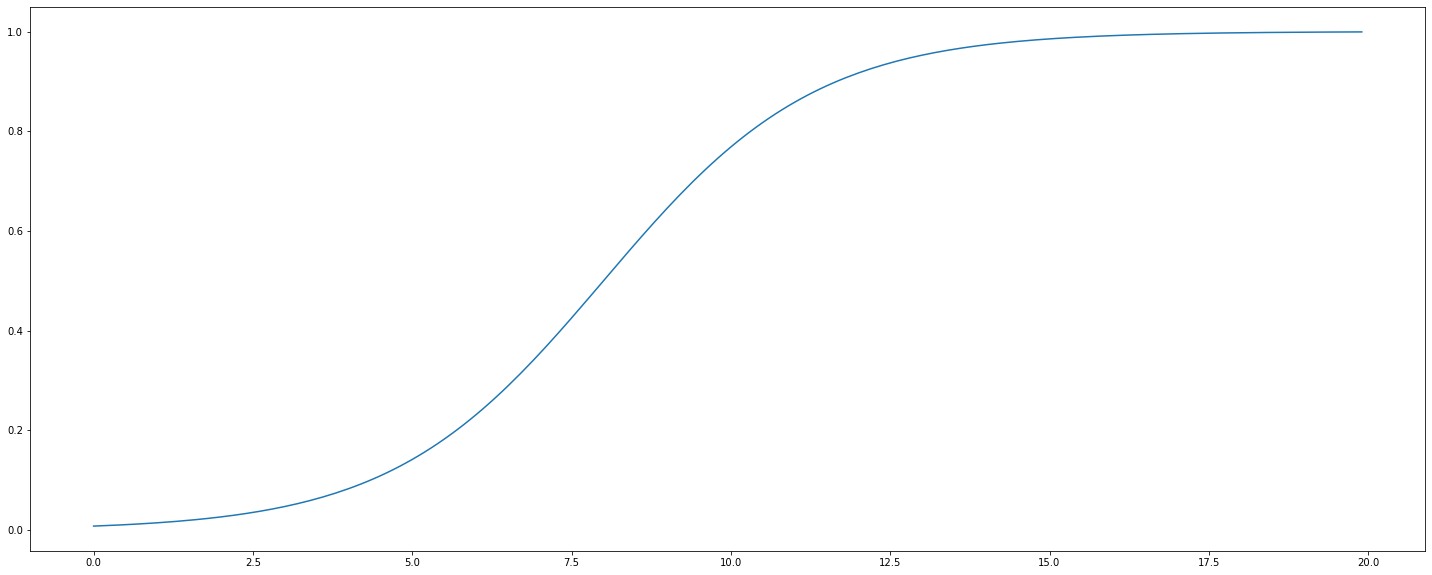

In [68]:
# The graph has the same shape as the one above.

X = np.arange(0, 20, 0.1)
Y = 1.0 / (1.0 + np.exp(0.6*(-X+8)))
plt.plot(X,Y) 
plt.show()

## Looking at the other variables

## Due to different scales do a boxplot of each variable seperately - some interesting points - power generated is mainly in 250-1600 kW range, wind is mostly between 5-10m/s (min 0, max 20m/s) and mainly from the southeast (100-170 degrees).

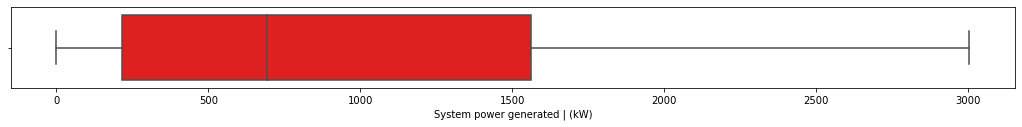

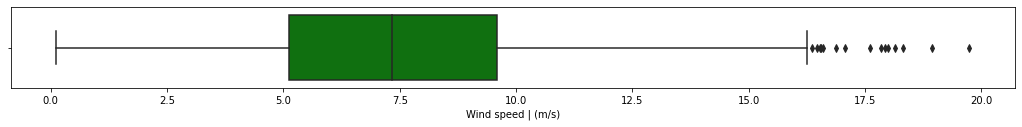

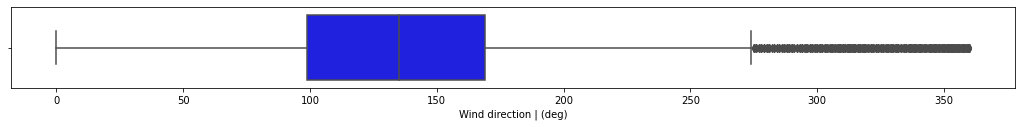

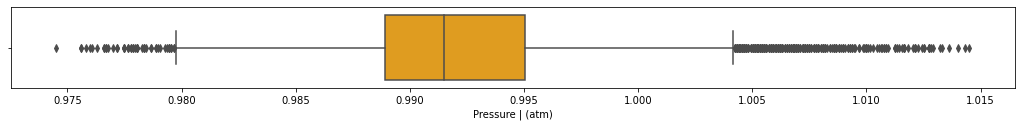

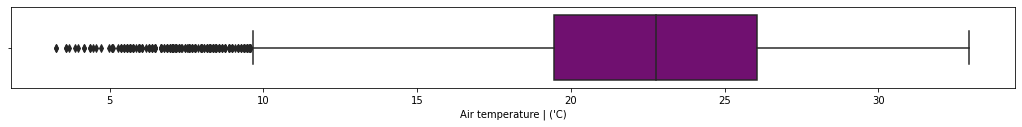

In [69]:
# boxplots - in different colours for better looks
colours = ['red','green','blue','orange','purple']
i=0
for column in df:    
    fig,ax = plt.subplots(figsize=(18,1.5))
    sns.boxplot(data=df, x=column, color=colours[i])#, ax=ax)
    i+=1
    

# Now to use this data to forecast for the next 24 hours.

## Essentially we need to train a model on either past data or a combination of the variables provided to see which gives the lowest error (ideally having a forecast of the wind speed would also be a useful comparison)

## Based on the correlations from the panda profiling above it would seem only wind speed is useful for forecasting power generated, then if wind speed is the only thing that correlates with the power output is there anything that correlates with the wind speed to aid in the prediction of wind speed and thus power output ?? - here is is only pressure that correlates to wind speed - which is logical as that is all wind is - namely the flow of air from areas of high pressure to areas of lower pressure (very simplified but look into the geostrophic wind for more in depth discussion)

<AxesSubplot:>

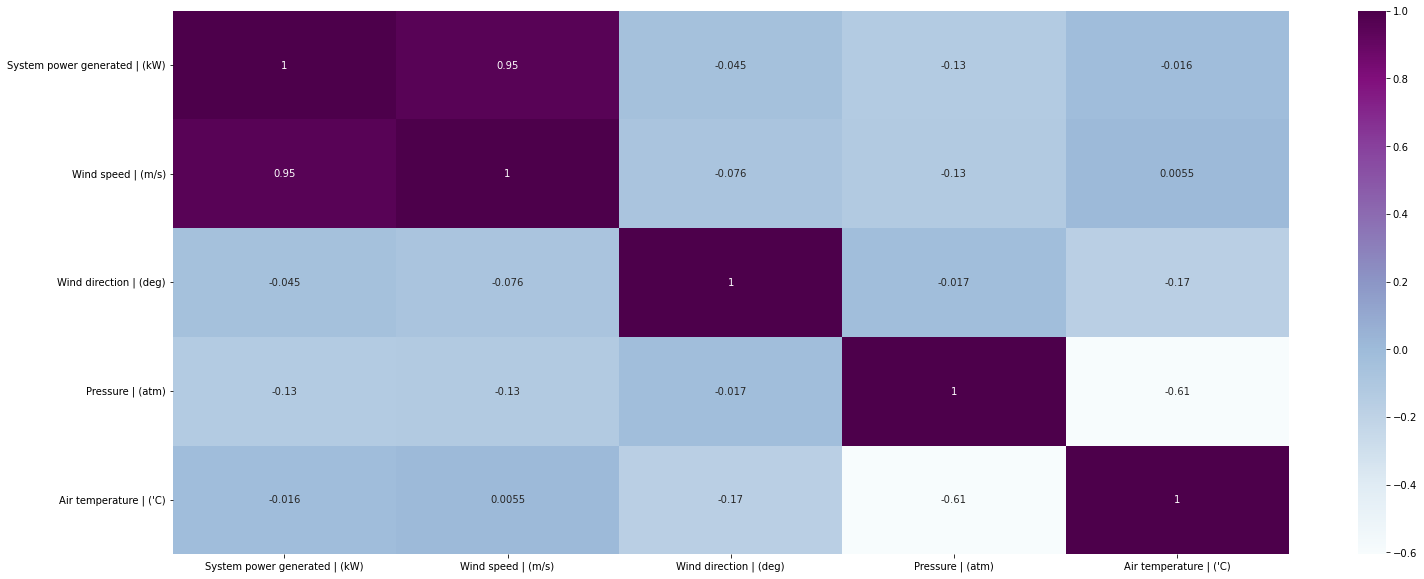

In [70]:
# First a heatmap of correlations
sns.heatmap(df.corr(), cmap="BuPu", annot=True)
#df.corr().style.background_gradient(cmap='coolwarm')

## So there is a high positive correlation between power generated and wind speed, and a negative correlation between pressue and very small negative correlation with air temperature. 

In [71]:
# Another way of viewing specific correlations
correlations = df.corr().unstack().sort_values(ascending=False).drop_duplicates()

# checking specific field
correlations['System power generated | (kW)']  # change the required field here to get the specific correlations

System power generated | (kW)    1.00000
Wind speed | (m/s)               0.95476
dtype: float64

In [72]:
correlations['Wind speed | (m/s)'] 

Pressure | (atm)   -0.128648
dtype: float64

# So now for some models (ignoring the pressure correlation above for simplicity).

## First set up train/test split - since it is a timeseries we don't want to split randomly. Some visualisations will be used to come up with the best strategy for splitting.

### The following visualisations show the hourly breakdown in the windiness, the monthly varation and then the daily - as expected the breakdown by hour shows that it is windier in afternoon/early evening as compared to the early morning. The second graph shows the breakdown by month with the windiest month being April and the least windy being September. The daily values show a lot of fluctuation, however, the general decrease in september and october can easily be seen.



Text(0.5, 1.0, 'Hourly boxplots of Power Generated')

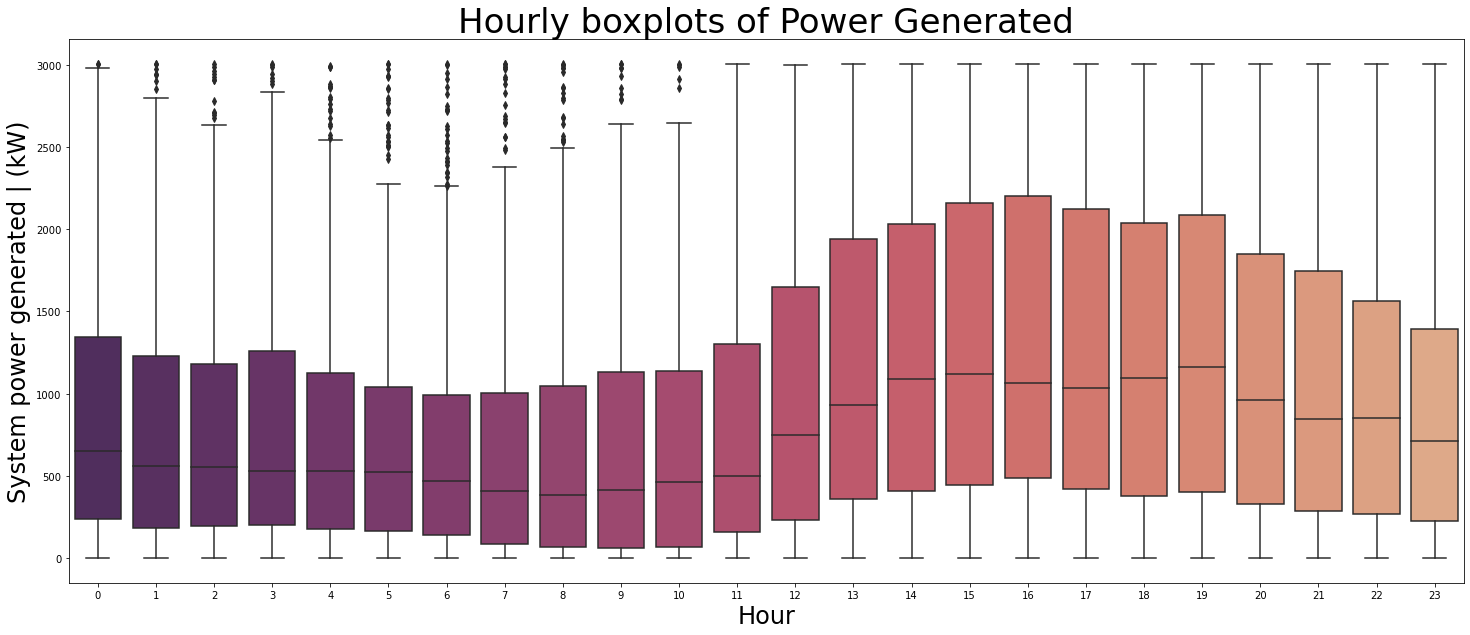

In [73]:
# Now to visualise amount generated by hour
sns.boxplot(x=df.index.hour, y='System power generated | (kW)', data=df, palette="flare_r")
plt.ylabel('System power generated | (kW)', fontsize=24)
plt.xlabel('Hour', fontsize=24)
plt.title("Hourly boxplots of Power Generated", fontsize=34)

Text(0.5, 1.0, 'Monthly boxplots of Power Generated')

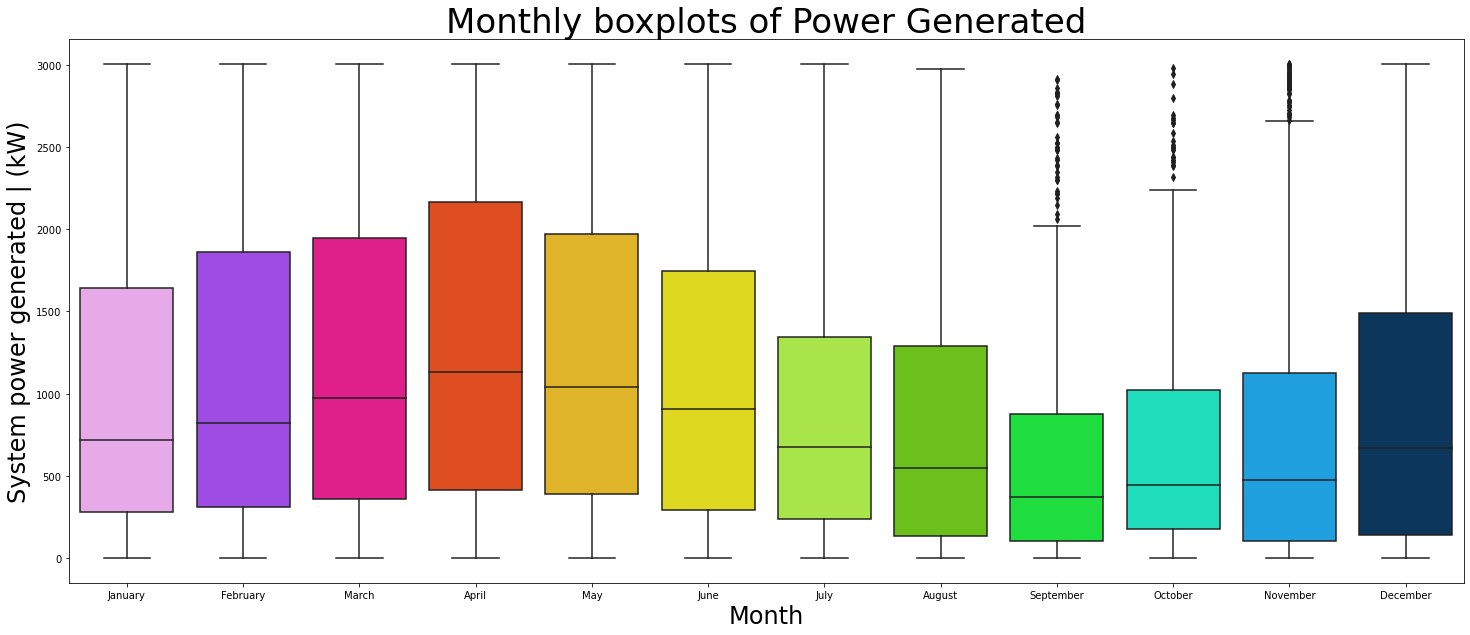

In [74]:
# Now to visualise amount generated by hour

sns.boxplot(x=df.index.month_name(), y='System power generated | (kW)', data=df, palette="gist_ncar_r")
plt.ylabel('System power generated | (kW)', fontsize=24)
plt.xlabel('Month', fontsize=24)
plt.title("Monthly boxplots of Power Generated", fontsize=34)

Text(0.5, 1.0, 'Daily power output')

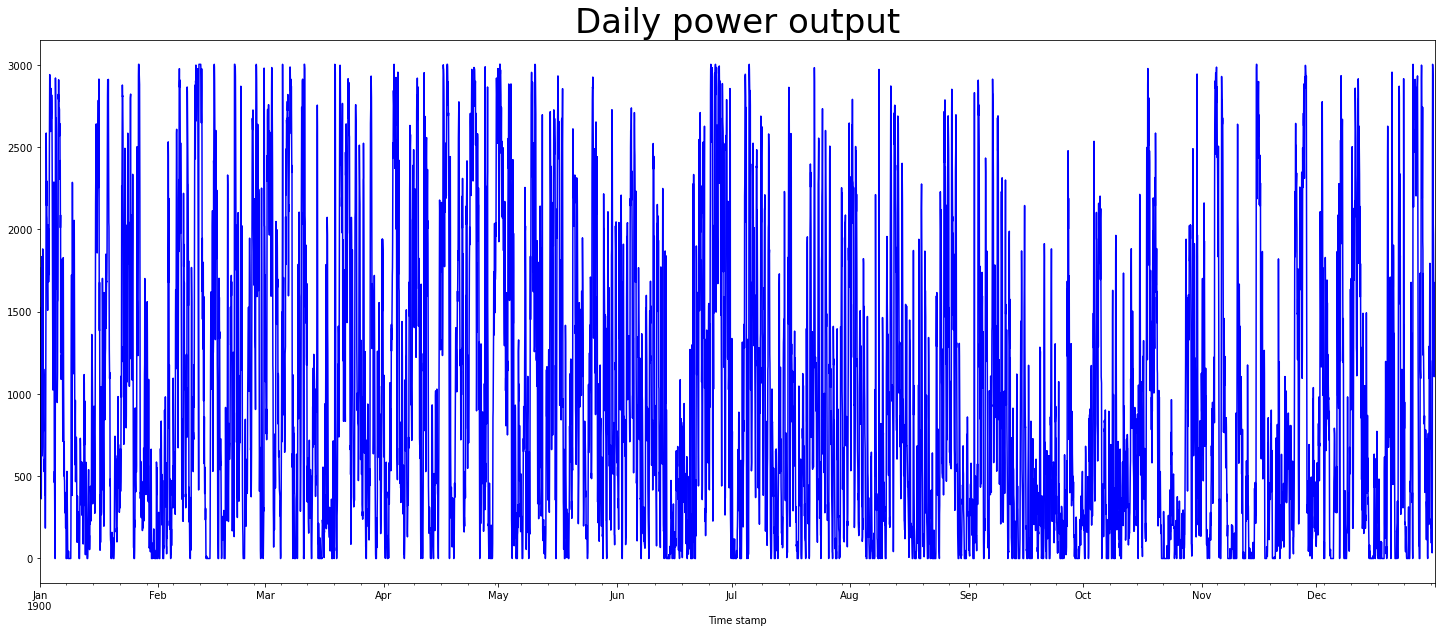

In [75]:
df['System power generated | (kW)'].plot.line(color='blue')
plt.title('Daily power output', fontsize=34)

# So because of this variation by month, when setting up the train test split the option Statify should be used so that a sample from each month is used - thus avoiding a training split of say the first 8 months when generation is high and then testing as the last 4 months when generation is not as high which may skew or bias results.

## Also just check the size and make sure they do infact have the same number of entries from each month - they do - looking at the monthly counts of features - so the training and test sets have been created by using some values from each month



In [76]:
scaler = StandardScaler() 
df_scaled = scaler.fit_transform(df)

# all columns except the power generated
X = df.drop('System power generated | (kW)', axis=1)
# the power generated
y = df['System power generated | (kW)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=X.index.month)

In [77]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7008, 4), (1752, 4), (7008,), (1752,))

In [78]:
# Test the numbers from each month to see every month is sampled
y_train.groupby([y_train.index.month]).agg('count'), X_train.groupby([X_train.index.month]).agg('count')

(Time stamp
 1     595
 2     538
 3     596
 4     576
 5     595
 6     576
 7     595
 8     595
 9     576
 10    595
 11    576
 12    595
 Name: System power generated | (kW), dtype: int64,
             Wind speed | (m/s)  Wind direction | (deg)  Pressure | (atm)  \
 Time stamp                                                                 
 1                          595                     595               595   
 2                          538                     538               538   
 3                          596                     596               596   
 4                          576                     576               576   
 5                          595                     595               595   
 6                          576                     576               576   
 7                          595                     595               595   
 8                          595                     595               595   
 9                          576   

In [79]:
#y_test.groupby([y_test.index.month]).agg('count'), X_test.groupby([X_test.index.month]).agg('count')

In [80]:
X_train

Wind speed | (m/s)  Wind direction | (deg)  \
Time stamp                                                        
1900-07-24 02:00:00               5.427                     184   
1900-07-05 15:00:00              15.333                     136   
1900-05-01 13:00:00              14.157                     106   
1900-10-31 16:00:00               6.792                     295   
1900-12-29 17:00:00               6.218                     280   
...                                 ...                     ...   
1900-06-04 03:00:00               9.224                     148   
1900-10-05 07:00:00              10.558                      15   
1900-06-29 17:00:00              12.961                     140   
1900-12-01 09:00:00               5.012                      77   
1900-02-18 17:00:00               5.793                     125   

                     Pressure | (atm)  Air temperature | ('C)  
Time stamp                                                     
1900-07-24 02:00:00          0.990998                  26.763  
1900-07-05 15:00:00          0.988332                  28.363  
1900-05-01 13:00:00          0.989026                  22.863  
1900-10-31 16:00:00          0.992580                  23.563  
1900-12-29 17:00:00          0.995055                  14.263  
...                               ...                     ...  
1900-06-04 03:00:00          0.990900                  26.163  
1900-10-05 07:00:00          0.992383                  23.263  
1900-06-29 17:00:00          0.984384                  26.663  
1900-12-01 09:00:00          0.990709                  17.663  
1900-02-18 17:00:00          0.987056                  18.563  

[7008 rows x 4 columns]

# The model - now with train/test split done it is time to build a model - need to scale the X data 

In [81]:
# also need to scale the data
scaler = StandardScaler()  #MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)



In [82]:
X_train

array([[-0.61673524,  0.4439777 , -0.25178639,  0.95194954],
       [ 2.53763855, -0.12732024, -0.75895201,  1.2847742 ],
       [ 2.16316413, -0.48438146, -0.62692915,  0.14068942],
       ...,
       [ 1.7823211 , -0.07971208, -1.50999848,  0.931148  ],
       [-0.74888395, -0.82954064, -0.30676421, -0.94099074],
       [-0.50018963, -0.25824269, -1.00169145, -0.75377686]])

# Function

## Create a function to run multiple regression algorithms and see which has the best results (Linear, decision tree, support vector, Lasso, random forest regression and extreme gradient boost) - this function will give some metrics for each algorithm and also some plots (zoomed in to show greater detail).

In [190]:
'''
Function to perform regressions, accuracy calculations and plots
'''    

def regression_calculations(X_train, y_train, X_test, y_test, regressor):
    #regr = regressor
    regr = regressor.fit(X_train,y_train)
    y_pred = regr.predict(X_test)
    # store the orignial and predicted value in a dataframe
    df_final = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_test })  
    # zoom in to 300 values - note due to stratification the samples are random and the whole timeseries appears
    df_final[1000:1300].plot()
    plt.title(regressor, fontsize=30)
    print('Accuragy for                                     ',regressor, ' = {:.4f}'.format(regr.score(X_test, y_test)))
    
    print('The Coefficient of determination (R-squared) for ',regressor, ' = {:.2f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
    print('The mean absolute percentage error (MAPE) for    ',regressor, ' = {:.2f}%'.format(mean_absolute_percentage_error( df_final['Actuals'],df_final['Predictions'])))
    print('The mean absolute error (MAE) for                ',regressor, ' = {:.2f}'.format(mean_absolute_error( df_final['Actuals'],df_final['Predictions'])))
    print('The RMSE error (RMSE) for                        ',regressor, ' = {:.2f}'.format(mean_squared_error( df_final['Actuals'],df_final['Predictions'])))
   
    
    print('\n\n')
    
    return y_pred

In [191]:
# define the different regressors
regressors = [LinearRegression(), DecisionTreeRegressor(), SVR(), linear_model.Lasso(), RandomForestRegressor(), GradientBoostingRegressor(), XGBRegressor()] 

Accuragy for                                      LinearRegression()  = 0.9153
The Coefficient of determination (R-squared) for  LinearRegression()  = 0.92
The mean absolute percentage error (MAPE) for     LinearRegression()  = 196422156785804800.00%
The mean absolute error (MAE) for                 LinearRegression()  = 213.69
The RMSE error (RMSE) for                         LinearRegression()  = 66315.64



Accuragy for                                      DecisionTreeRegressor()  = 0.9995
The Coefficient of determination (R-squared) for  DecisionTreeRegressor()  = 1.00
The mean absolute percentage error (MAPE) for     DecisionTreeRegressor()  = 0.04%
The mean absolute error (MAE) for                 DecisionTreeRegressor()  = 15.93
The RMSE error (RMSE) for                         DecisionTreeRegressor()  = 394.76



Accuragy for                                      SVR()  = 0.6400
The Coefficient of determination (R-squared) for  SVR()  = 0.64
The mean absolute percentage error (M

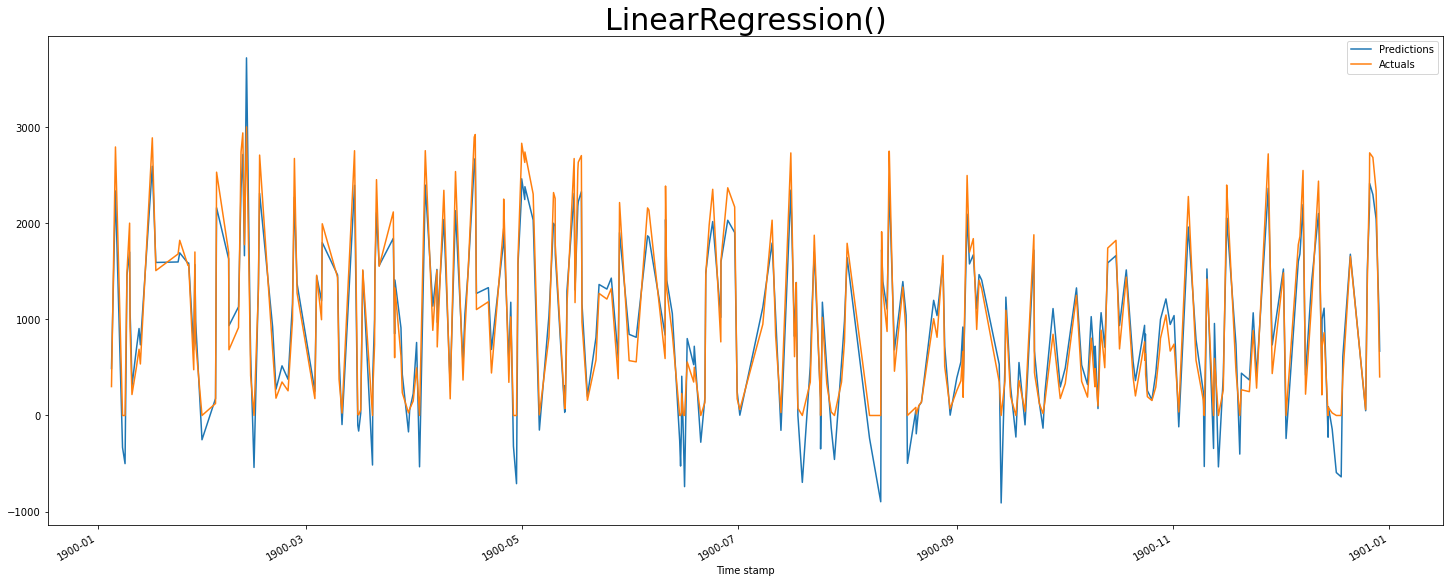

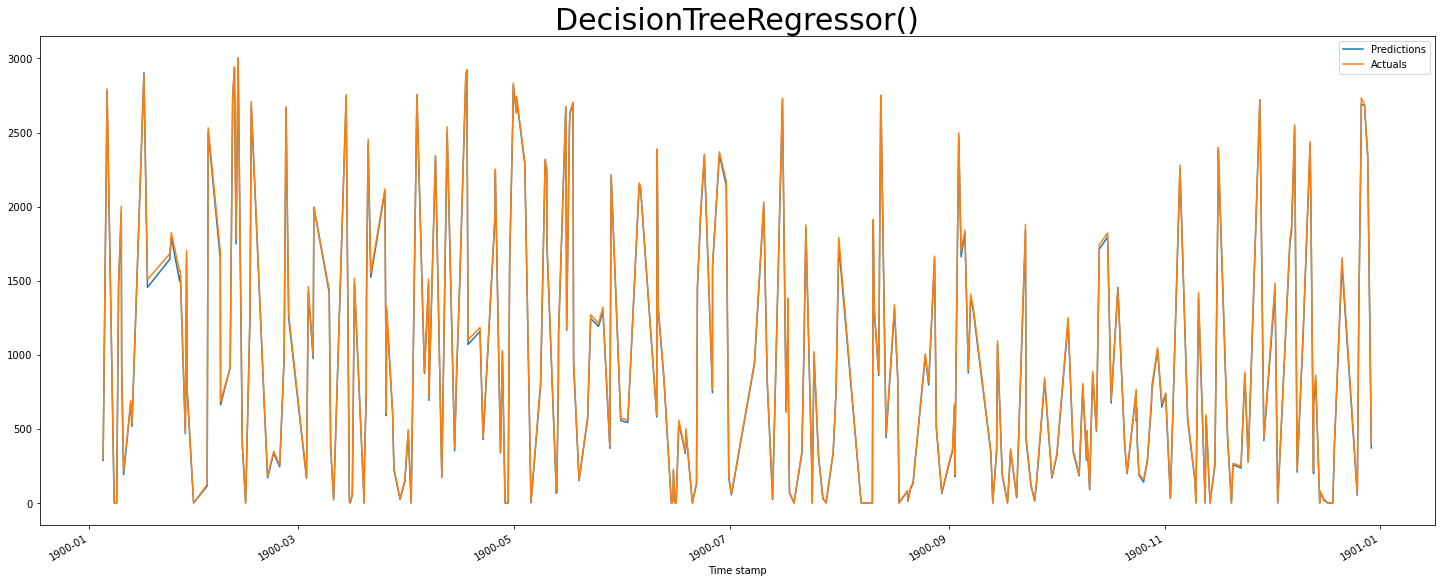

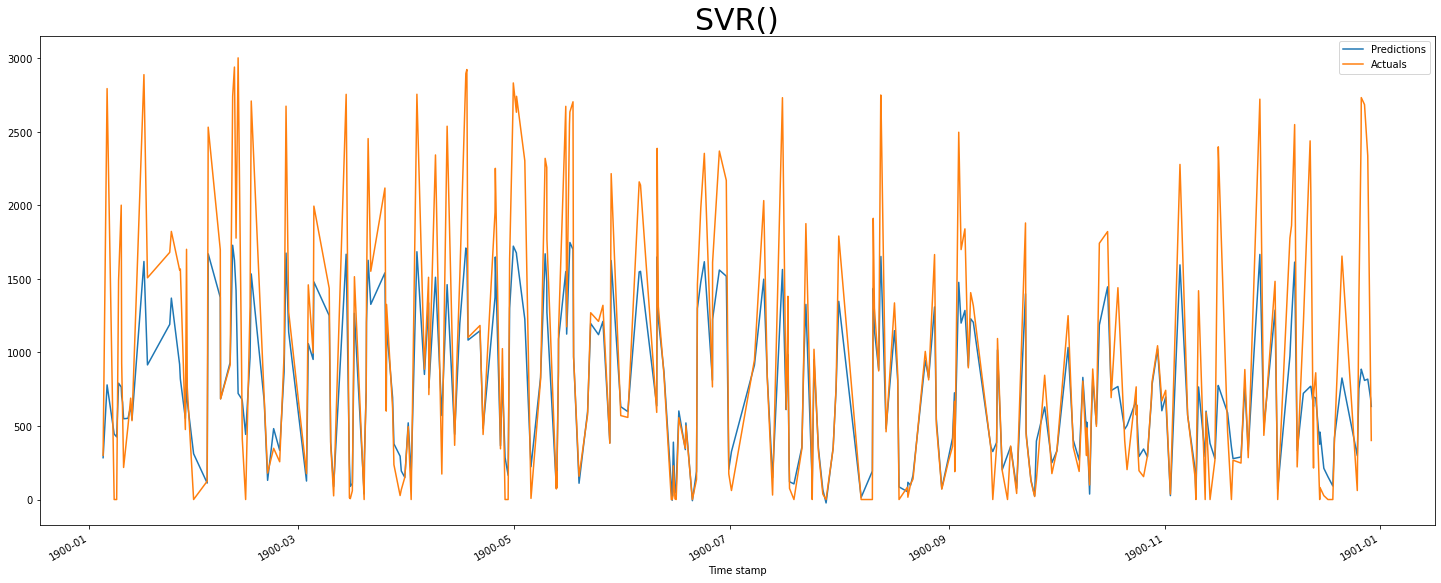

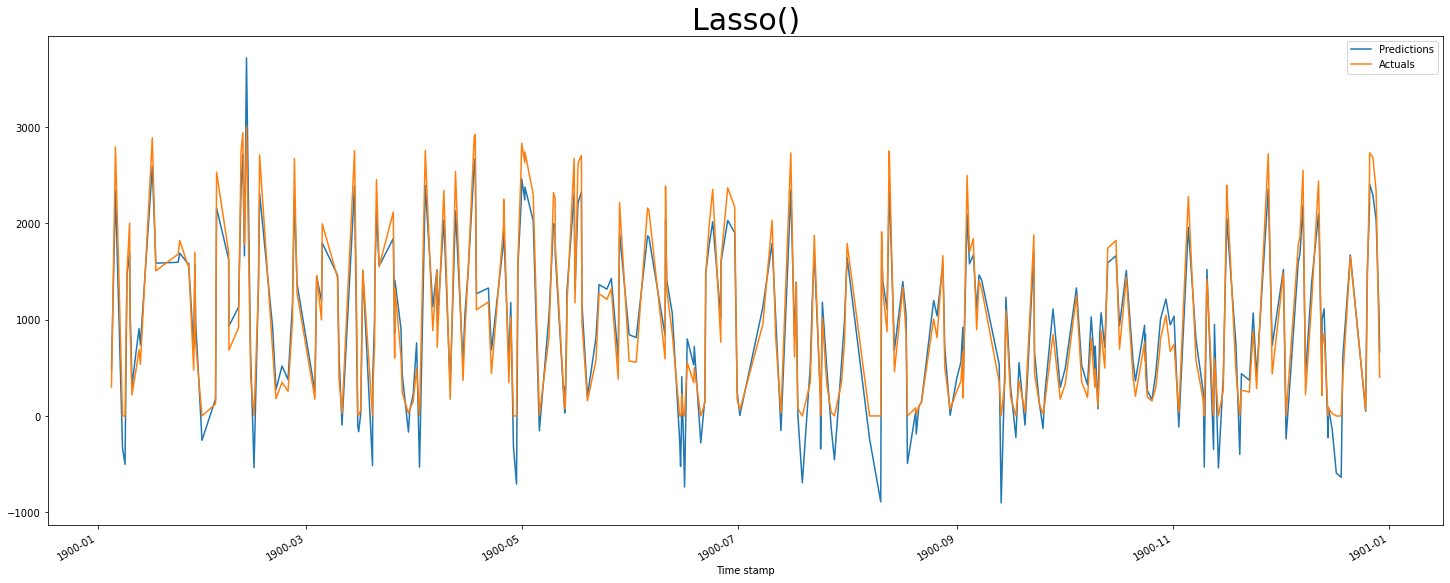

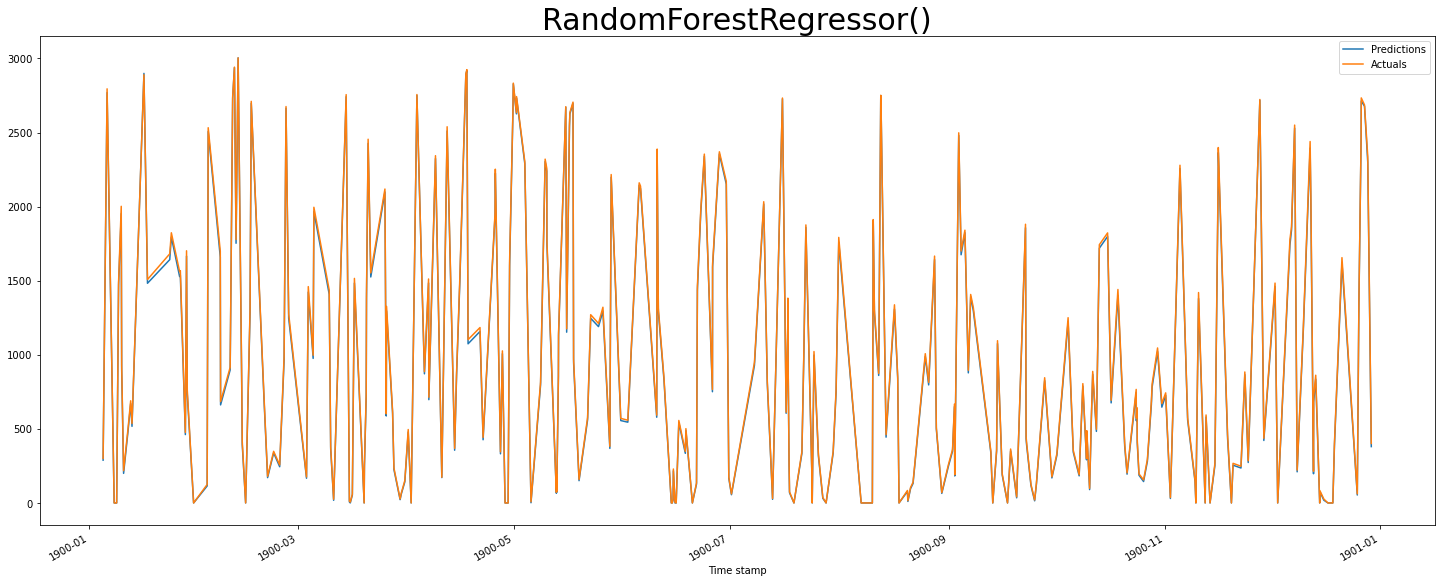

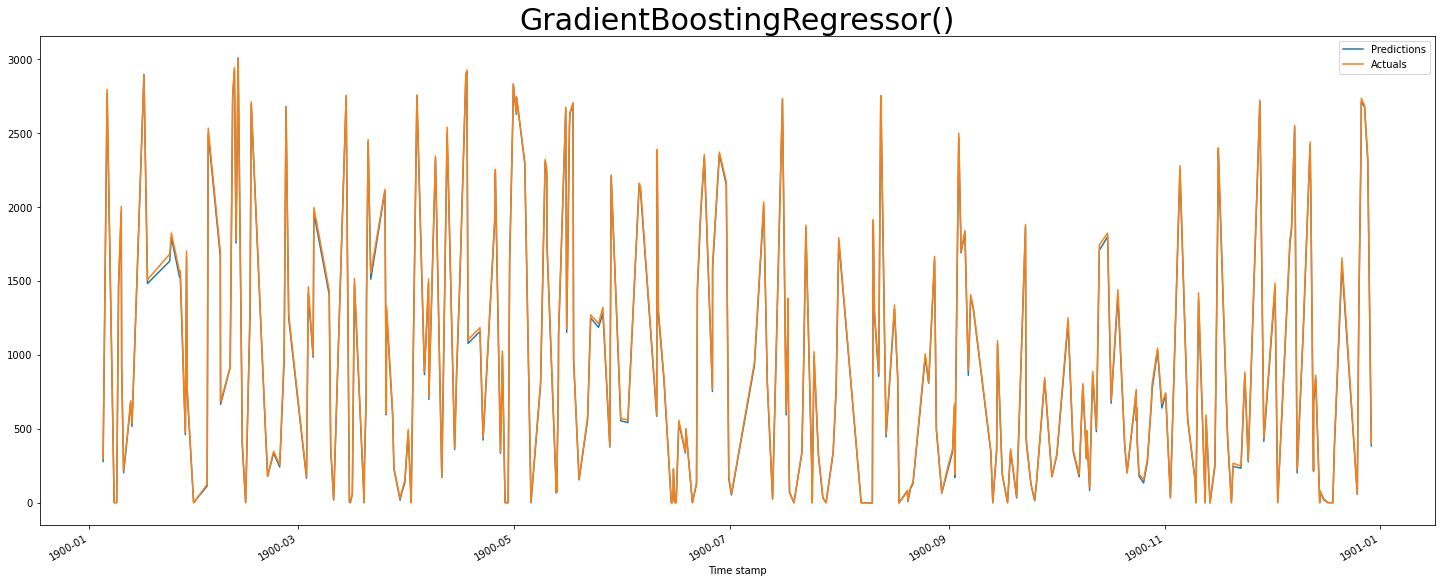

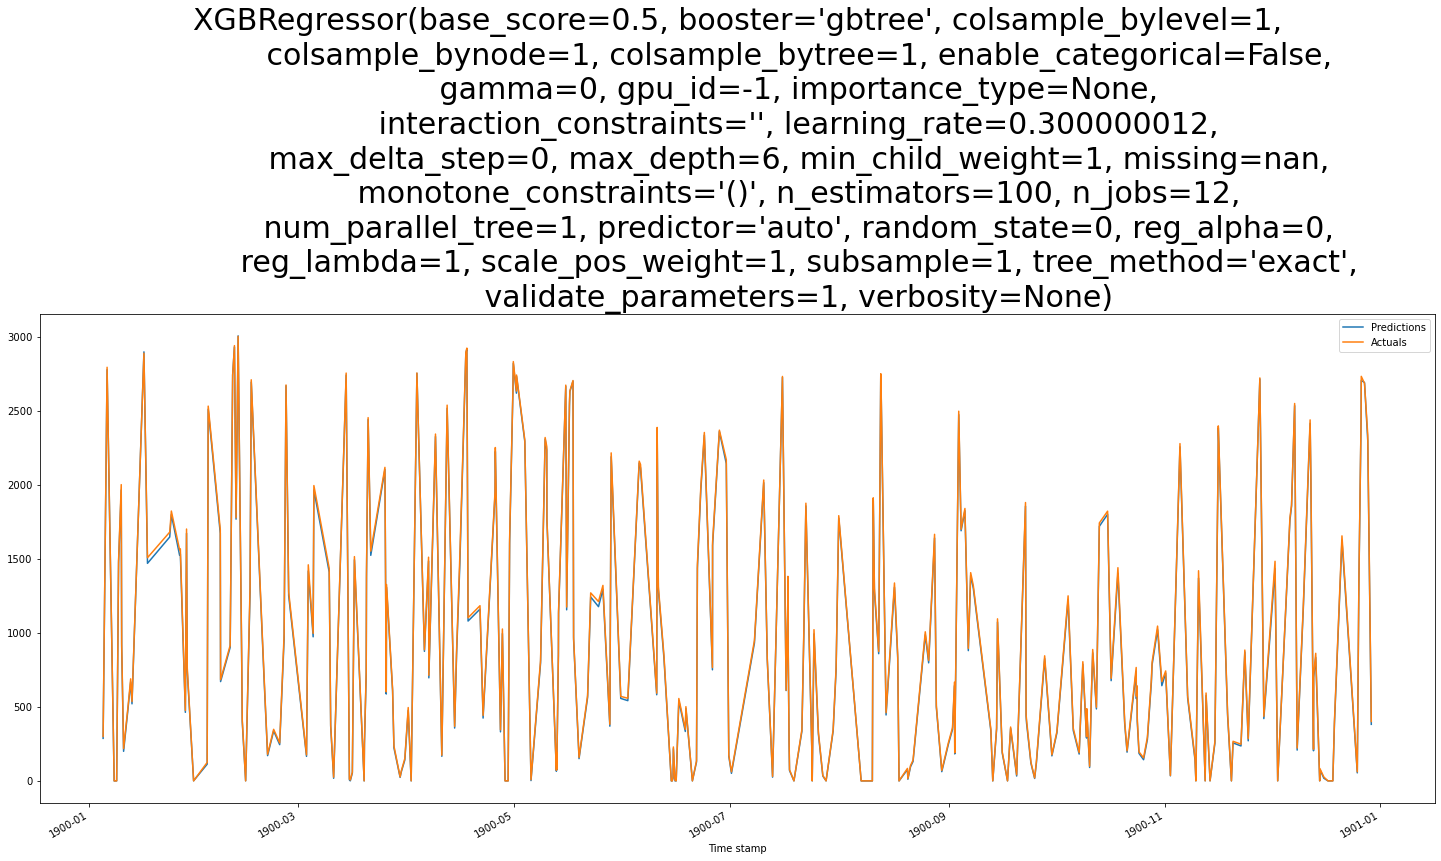

In [192]:
pred=0
for regressor in regressors:
    pred = regression_calculations(X_train, y_train, X_test, y_test, regressor)
    #print(pred)

## Even though the regression results are very good and the problem is probably to simple to need a LSTM network I will do it here for completeness.

# Results

## The graphs above provide an excellent visualisation of the model performance, with DescisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor and XGBRegressor all producing excellent predictions that are very close to the actual values. This is also shown by the metrics - specifically the high accuracy score and the perfect R-squared value. The values for MAPE, MAE and RMSE produce wildy varying answers in these cases - some show the accuracy others do not.

## It should also be noted that there was no need to perform cross validation or use any parameters (other than the defaults) for these regressors as the initial implementations proved very accurate to start with.